In [1]:
%load_ext autoreload
%autoreload 2

### Basic Imports

In [2]:
import nbimporter
from typing import Dict, Tuple, List
import numpy as np
from tqdm import tqdm

### Env Vars

In [3]:
QUBITS_NUM = 4 
N = 2**QUBITS_NUM

NUM_SHOTS = 1024
NUM_ITERATIONS = 100

CIRCUIT_DEPTH = 3
PARAMS_NUM = 2*QUBITS_NUM*(CIRCUIT_DEPTH+1)

### Simulator Backend

In [4]:
from qiskit import Aer
from qiskit.utils import QuantumInstance, algorithm_globals

seed = 50
algorithm_globals.random_seed = seed

simulator_backend = Aer.get_backend('qasm_simulator')

### BFGS Optimizer

In [5]:
from scipy.optimize import minimize

### Ansatz State

In [6]:
from linear_entangelment_and_full_entangelment_ansatz_circuits import *

In [7]:
def get_ansatz_state(thetas, ansatz_entangelment, input_state):
    if ansatz_entangelment=="full":
        return get_full_entangelment_ansatz(QUBITS_NUM, thetas, input_state)
    if ansatz_entangelment=="linear":
        return get_linear_entangelment_ansatz(QUBITS_NUM, thetas, input_state)

## Expectation Value

### convert hamiltonian to pauli strings

In [8]:
def transfrom_hamiltonian_into_pauli_strings(hamiltonian) -> List:
    pauli_operators = hamiltonian.to_pauli_op().settings['oplist']
    pauli_coeffs = list(map(lambda pauli_operator: pauli_operator.coeff, pauli_operators))
    pauli_strings = list(map(lambda pauli_operator: pauli_operator.primitive, pauli_operators))
    return pauli_coeffs, pauli_strings

### pauli string reduction to sigma_z's

In [9]:
from qiskit.circuit.library.standard_gates import HGate, SGate
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister

In [10]:
reducing_to_pauli_z_mapping = {
    'I': 'I',
    'Z': 'Z',
    'X': 'Z',
    'Y': 'Z'
} 

In [11]:
def reduce_pauli_matrixes_into_sigma_z(pauli_string) -> str:
    reduced_pauli_string = ""
    for matrix_index in range(QUBITS_NUM):
        pauli_matrix = str(pauli_string[matrix_index])
        reduced_pauli_matrix = reducing_to_pauli_z_mapping[pauli_matrix]
        reduced_pauli_string = reduced_pauli_matrix + reduced_pauli_string
    
    return reduced_pauli_string

In [12]:
def add_layer_of_gates_for_reducing_paulis_to_sigma_z(pauli_string, quantum_circuit):
    quantum_registers = QuantumRegister(QUBITS_NUM, name="qubit")
    additional_circuit_layer = QuantumCircuit(quantum_registers)
    
    for quantum_register_index, pauli_matrix in enumerate(pauli_string):
        if pauli_matrix == "X":
            additional_circuit_layer.append(HGate(), [quantum_registers[quantum_register_index]])
        if pauli_string == "Y":
            additional_circuit_layer.append(HGate(), [quantum_registers[quantum_register_index]])
            additional_circuit_layer.append(SGate(), [quantum_registers[quantum_register_index]])
                
    extended_quantum_circuit = quantum_circuit.compose(additional_circuit_layer)
    return extended_quantum_circuit

### probabilities distribution

In [13]:
def get_probability_distribution(counts: Dict) -> Dict:
    proba_distribution = {state: (count / NUM_SHOTS) for state, count in counts.items()}
    return proba_distribution

def calculate_probabilities_of_measurments_in_computational_basis(quantum_state_circuit) -> Dict:
    quantum_state_circuit.measure_all()
    
    transpiled_quantum_state_circuit = transpile(quantum_state_circuit, simulator_backend) 
    Qobj = assemble(transpiled_quantum_state_circuit)
    result = simulator_backend.run(Qobj).result()
    counts = result.get_counts(quantum_state_circuit)
    
    return get_probability_distribution(counts)

### Expectation value from probabilities

In [14]:
def sort_probas_dict_by_qubits_string_keys(proba_distribution: Dict) -> Dict:
    return dict(sorted(proba_distribution.items()))

def reset_power_of_minus_1(power_of_minus_1):
    power_of_minus_1 = 0
    return power_of_minus_1

def convert_pauli_string_into_str(pauli_string) -> str:
    return str(pauli_string)

def calculate_expectation_value_of_pauli_string_by_measurments_probas(pauli_string, ansatz_circuit):
    pauli_string_expectation_value = 0
    power_of_minus_1 = 0
    
    pauli_string_str = convert_pauli_string_into_str(pauli_string)
    extended_ansatz_circuit = add_layer_of_gates_for_reducing_paulis_to_sigma_z(pauli_string_str, ansatz_circuit)
    probas_distribution = calculate_probabilities_of_measurments_in_computational_basis(extended_ansatz_circuit)
    
    reduced_pauli_string = reduce_pauli_matrixes_into_sigma_z(pauli_string)
    sorted_probas_distribuition = sort_probas_dict_by_qubits_string_keys(probas_distribution)
    for qubits_string, proba in sorted_probas_distribuition.items():
        for string_index in range(QUBITS_NUM):
            if(str(qubits_string[string_index])=="1" and str(reduced_pauli_string[string_index])=="Z"):
                power_of_minus_1 += 1
            
        pauli_string_expectation_value += pow(-1, power_of_minus_1)*proba
        power_of_minus_1 = reset_power_of_minus_1(power_of_minus_1)
        
    return pauli_string_expectation_value

In [15]:
def get_expectation_value(ansatz_circuit, pauli_coeffs, pauli_strings):
    total_expection_value = 0
    
    for pauli_coeff, pauli_string in tqdm(zip(pauli_coeffs, pauli_strings)):
        total_expection_value += pauli_coeff*calculate_expectation_value_of_pauli_string_by_measurments_probas(
                                                                                    pauli_string, ansatz_circuit)
    
    return total_expection_value

## Objective Function

In [16]:
from qiskit import assemble, transpile

def cost_function(thetas, hamiltonian, ansatz_entangelment):
    initial_eigenvector = np.identity(N)[0]
    
    pauli_coeffs, pauli_strings = transfrom_hamiltonian_into_pauli_strings(hamiltonian)
    ansatz_state = get_ansatz_state(thetas, ansatz_entangelment, initial_eigenvector)
        
    L = get_expectation_value(ansatz_state, pauli_coeffs, pauli_strings)
    insert_approximated_energy_to_list_of_all_approximated_energies(L)
        
    return L

## Optimization

In [17]:
def get_optimal_thetas_of_ansatz_circuit_for_hamiltonian(hamiltonian, ansatz_entangelment):
    initial_thetas = np.random.uniform(low=0, high=2*np.pi, size=PARAMS_NUM)
    optimizer_result = minimize(cost_function,
                                x0=initial_thetas,
                                args=(hamiltonian, ansatz_entangelment),
                                method="COBYLA",
                                options={"maxiter":NUM_ITERATIONS,
                                        "disp": True})
    optimal_thetas = optimizer_result.x
    
    return optimal_thetas

In [18]:
def get_approximated_eigenvalue_of_hamiltonian(hamiltonian, ansatz_entangelment):
    optimal_thetas = get_optimal_thetas_of_ansatz_circuit_for_hamiltonian(hamiltonian, ansatz_entangelment)
    print(optimal_thetas)
    initial_eigenvector = np.identity(N)[0]
    optimal_ansatz_state = get_ansatz_state(optimal_thetas, ansatz_entangelment, initial_eigenvector)
    
    pauli_coeffs, pauli_strings = transfrom_hamiltonian_into_pauli_strings(hamiltonian)
    approximated_eigenvalue = get_expectation_value(optimal_ansatz_state, pauli_coeffs, pauli_strings)

    return approximated_eigenvalue

## Comparsion

In [19]:
from numpy import linalg as LA

def get_approximation_error(exact_eigenvalue, approximated_eigenvalue):
    return abs(abs(exact_eigenvalue)-abs(approximated_eigenvalue))/abs(exact_eigenvalue)

In [20]:
def get_minimum_exact_eigenvalue_of_hamiltonian(hamiltonian):
    eigen_values = LA.eigvals(hamiltonian.to_matrix())
    print(sorted(eigen_values))
    
    return min(sorted(eigen_values))

In [21]:
def compare_exact_and_approximated_eigenvalue(hamiltonian, approximated_eigenvalue):
    exact_eigenvalue = get_minimum_exact_eigenvalue_of_hamiltonian(hamiltonian)
    print("Exact Eigenvalue:")
    print(exact_eigenvalue)
    print("\nApproximated Eigenvalue:")
    print(approximated_eigenvalue)

    print("\nApproximation Error")
    print(get_approximation_error(exact_eigenvalue, approximated_eigenvalue))
    
    plot_convergence_of_optimization_process(approximated_energies, exact_eigenvalue, margin=3)
    initialize_approximated_energy_to_list_of_all_approximated_energies()

## Visualization

In [22]:
approximated_energies = []

In [23]:
def insert_approximated_energy_to_list_of_all_approximated_energies(energy):
    approximated_energies.append(energy)

In [24]:
def initialize_approximated_energy_to_list_of_all_approximated_energies():
    approximated_energies = []

In [25]:
import matplotlib.pyplot as plt

def plot_convergence_of_optimization_process(approximated_energies, exact_eigenvalue, margin):
    plt.title("convergence of optimization process to the exact eigenvalue")
    plt.margins(0, margin)
    plt.plot(approximated_energies)
    plt.axhline(y = exact_eigenvalue, color = 'r', linestyle = '-')
    plt.grid()
    plt.xlabel("# of iterations")
    plt.ylabel("Energy")
    
def plot_fidelity():
    plt.plot(LiH_approximated_energies)
    plt.xlabel("# of iterations")
    plt.ylabel("Energy")

## LiH Molecule 4 qubits

In [26]:
from qiskit.opflow import X, Z, I, H, Y

LiH_molecule_4_qubits = -7.49894690201071*(I^I^I^I) + \
                            -0.0029329964409502266*(X^X^Y^Y) + \
                            0.0029329964409502266*(X^Y^Y^X) + \
                            0.01291078027311749*(X^Z^X^I) + \
                            -0.0013743761078958677*(X^Z^X^Z) + \
                            0.011536413200774975*(X^I^X^I) + \
                            0.0029329964409502266*(Y^X^X^Y) + \
                            -0.0029329964409502266*(Y^Y^X^X) + \
                            0.01291078027311749*(Y^Z^Y^I) + \
                            -0.0013743761078958677*(Y^Z^Y^Z) + \
                            0.011536413200774975*(Y^I^Y^I) + \
                            0.16199475388004184*(Z^I^I^I) + \
                            0.011536413200774975*(Z^X^Z^X) + \
                            0.011536413200774975*(Z^Y^Z^Y) + \
                            0.12444770133137588*(Z^Z^I^I) + \
                            0.054130445793298836*(Z^I^Z^I) + \
                            0.05706344223424907*(Z^I^I^Z) + \
                            0.012910780273117487*(I^X^Z^X) + \
                            -0.0013743761078958677*(I^X^I^X) + \
                            0.012910780273117487*(I^Y^Z^Y) + \
                            -0.0013743761078958677*(I^Y^I^Y) + \
                            0.16199475388004186*(I^Z^I^I) + \
                            0.05706344223424907*(I^Z^Z^I) + \
                            0.054130445793298836*(I^Z^I^Z) + \
                            -0.013243698330265966*(I^I^Z^I) + \
                            0.08479609543670981*(I^I^Z^Z) + \
                            -0.013243698330265952*(I^I^I^Z)

#### Linear Entangelment

In [27]:
%%time
LiH_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(LiH_molecule_4_qubits, "linear")

27it [00:03,  7.03it/s]
27it [00:02, 11.32it/s]
27it [00:02, 11.82it/s]
27it [00:02, 11.74it/s]
27it [00:02, 11.63it/s]
27it [00:02, 11.06it/s]
27it [00:02, 11.17it/s]
27it [00:02, 11.59it/s]
27it [00:02, 11.01it/s]
27it [00:02, 10.35it/s]
27it [00:02, 10.80it/s]
27it [00:02, 10.89it/s]
27it [00:02, 10.27it/s]
27it [00:02, 10.04it/s]
27it [00:02,  9.56it/s]
27it [00:02,  9.22it/s]
27it [00:02,  9.62it/s]
27it [00:02, 11.22it/s]
27it [00:02, 10.27it/s]
27it [00:02, 11.17it/s]
27it [00:02, 10.91it/s]
27it [00:02, 10.79it/s]
27it [00:02, 10.38it/s]
27it [00:02, 10.16it/s]
27it [00:02, 10.01it/s]
27it [00:02, 10.85it/s]
27it [00:02, 12.02it/s]
27it [00:02, 12.11it/s]
27it [00:02, 11.12it/s]
27it [00:02, 10.35it/s]
27it [00:02, 10.72it/s]
27it [00:02, 10.97it/s]
27it [00:02, 11.22it/s]
27it [00:02, 11.20it/s]
27it [00:02, 11.05it/s]
27it [00:02, 10.25it/s]
27it [00:02, 10.61it/s]
27it [00:02, 10.16it/s]
27it [00:02, 10.48it/s]
27it [00:02,  9.34it/s]
27it [00:02, 10.98it/s]
27it [00:02, 10.

[ 3.59592819e+00  2.82774633e+00  4.15463566e+00  5.80468805e+00
  1.85728216e+00  6.08561373e-01 -3.43968222e-03  4.51519836e+00
  3.35073250e+00  4.67054130e+00  4.22413993e+00  1.62259968e+00
  4.72411176e+00  6.15032423e+00  2.18842286e+00  6.17625825e+00
  1.97118182e-01  2.13764089e+00  1.87490154e+00  1.06099283e+00
  1.53597445e+00  3.12648818e+00  4.94434990e+00 -1.23886279e-02
 -6.03341288e-02  5.96956251e+00  5.22028635e+00  3.80008338e+00
  3.25819624e-01  1.90106943e+00  5.34412764e+00  2.28077658e+00]


27it [00:03,  8.77it/s]

CPU times: total: 4min 29s
Wall time: 4min 37s


### Comparsion between approximate value after optimtimzation and exact eigenvalue

[(-7.862773163027979+0j), (-7.7833962082865185+0j), (-7.783396208286518+0j), (-7.7140566916607005+0j), (-7.714056691660695+0j), (-7.714056691660695+0j), (-7.700475837803976+0j), (-7.569984737620559+0j), (-7.569984737620559+0j), (-7.511999706834453+0j), (-7.511999706834451+0j), (-7.364817440287081+0j), (-7.151525481896562+0j), (-7.130406955301309+0j), (-7.130406955301308+0j), (-6.769813218087976+0j)]
Exact Eigenvalue:
(-7.862773163027979+0j)

Approximated Eigenvalue:
-7.785583502595832

Approximation Error
0.009817103817150046


C:\Users\hadar\anaconda3\envs\Qiskitenv\lib\site-packages\matplotlib\cbook\__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


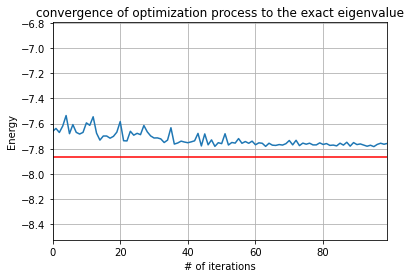

In [28]:
compare_exact_and_approximated_eigenvalue(LiH_molecule_4_qubits, LiH_approximated_eigenvalue)

#### Full Entangelment

In [29]:
%%time
LiH_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(LiH_molecule_4_qubits, "full")

27it [00:02,  9.08it/s]
27it [00:02,  9.47it/s]
27it [00:02,  9.21it/s]
27it [00:03,  9.00it/s]
27it [00:02,  9.07it/s]
27it [00:03,  8.75it/s]
27it [00:02,  9.21it/s]
27it [00:03,  8.36it/s]
27it [00:03,  8.75it/s]
27it [00:02,  9.36it/s]
27it [00:03,  8.58it/s]
27it [00:03,  8.83it/s]
27it [00:02,  9.58it/s]
27it [00:02,  9.01it/s]
27it [00:03,  8.45it/s]
27it [00:02,  9.10it/s]
27it [00:03,  8.85it/s]
27it [00:03,  8.78it/s]
27it [00:03,  8.44it/s]
27it [00:03,  8.79it/s]
27it [00:03,  8.56it/s]
27it [00:03,  8.14it/s]
27it [00:03,  8.97it/s]
27it [00:03,  8.96it/s]
27it [00:03,  8.37it/s]
27it [00:03,  8.52it/s]
27it [00:03,  8.44it/s]
27it [00:03,  8.23it/s]
27it [00:03,  8.40it/s]
27it [00:03,  8.54it/s]
27it [00:03,  8.52it/s]
27it [00:03,  8.80it/s]
27it [00:03,  8.23it/s]
27it [00:03,  8.27it/s]
27it [00:03,  8.56it/s]
27it [00:03,  8.20it/s]
27it [00:03,  7.99it/s]
27it [00:03,  8.66it/s]
27it [00:03,  8.49it/s]
27it [00:03,  7.67it/s]
27it [00:03,  8.50it/s]
27it [00:03,  8.

[0.70150525 0.25216983 5.70924155 1.26829894 2.23324127 2.50015727
 5.24814127 2.39795348 4.29055268 5.75210256 5.91187436 4.92911132
 5.95787879 1.51460929 6.03287917 4.06836839 4.59547465 2.66127368
 4.51662261 5.72895637 0.20884228 5.3797326  4.22893026 0.27105588
 0.86179379 4.98871131 2.00922188 1.8315762  2.58945588 2.7438802
 4.89215904 6.98989637]


27it [00:03,  7.47it/s]

CPU times: total: 5min 22s
Wall time: 5min 43s


[(-7.862773163027979+0j), (-7.7833962082865185+0j), (-7.783396208286518+0j), (-7.7140566916607005+0j), (-7.714056691660695+0j), (-7.714056691660695+0j), (-7.700475837803976+0j), (-7.569984737620559+0j), (-7.569984737620559+0j), (-7.511999706834453+0j), (-7.511999706834451+0j), (-7.364817440287081+0j), (-7.151525481896562+0j), (-7.130406955301309+0j), (-7.130406955301308+0j), (-6.769813218087976+0j)]
Exact Eigenvalue:
(-7.862773163027979+0j)

Approximated Eigenvalue:
-7.756476736389585

Approximation Error
0.013518948650104418


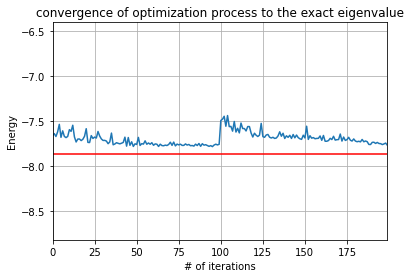

In [30]:
compare_exact_and_approximated_eigenvalue(LiH_molecule_4_qubits, LiH_approximated_eigenvalue)

## H2 Molecule 4 qubits

In [31]:
H2_molecule_Hamiltonian_4_qubits =  -0.8105479805373279 * (I^I^I^I) \
                                    + 0.1721839326191554 * (I^I^I^Z) \
                                    - 0.22575349222402372 * (I^I^Z^I) \
                                    + 0.17218393261915543 * (I^Z^I^I) \
                                    - 0.2257534922240237 * (Z^I^I^I) \
                                    + 0.12091263261776627 * (I^I^Z^Z) \
                                    + 0.16892753870087907 * (I^Z^I^Z) \
                                    + 0.045232799946057826 * (Y^Y^Y^Y) \
                                    + 0.045232799946057826 * (X^X^Y^Y) \
                                    + 0.045232799946057826 * (Y^Y^X^X) \
                                    + 0.045232799946057826 * (X^X^X^X) \
                                    + 0.1661454325638241 * (Z^I^I^Z) \
                                    + 0.1661454325638241 * (I^Z^Z^I) \
                                    + 0.17464343068300453 * (Z^I^Z^I) \
                                    + 0.12091263261776627 * (Z^Z^I^I)

#### Linear Entangelment

In [32]:
%%time
H2_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(H2_molecule_Hamiltonian_4_qubits, "linear")

15it [00:02,  7.13it/s]
15it [00:01,  7.61it/s]
15it [00:01,  7.55it/s]
15it [00:02,  7.16it/s]
15it [00:01,  7.91it/s]
15it [00:01,  7.77it/s]
15it [00:02,  6.82it/s]
15it [00:02,  6.31it/s]
15it [00:02,  6.72it/s]
15it [00:02,  5.97it/s]
15it [00:02,  5.46it/s]
15it [00:02,  6.50it/s]
15it [00:01,  7.70it/s]
15it [00:02,  6.31it/s]
15it [00:02,  6.75it/s]
15it [00:02,  7.24it/s]
15it [00:02,  7.08it/s]
15it [00:02,  6.89it/s]
15it [00:01,  7.64it/s]
15it [00:02,  7.13it/s]
15it [00:02,  7.42it/s]
15it [00:02,  7.44it/s]
15it [00:02,  7.45it/s]
15it [00:02,  7.28it/s]
15it [00:02,  7.01it/s]
15it [00:02,  7.02it/s]
15it [00:02,  7.15it/s]
15it [00:02,  6.60it/s]
15it [00:02,  7.05it/s]
15it [00:02,  7.01it/s]
15it [00:01,  7.70it/s]
15it [00:01,  7.90it/s]
15it [00:01,  7.90it/s]
15it [00:01,  8.01it/s]
15it [00:01,  7.84it/s]
15it [00:01,  7.58it/s]
15it [00:01,  7.80it/s]
15it [00:01,  7.58it/s]
15it [00:01,  7.81it/s]
15it [00:02,  7.28it/s]
15it [00:02,  7.37it/s]
15it [00:02,  7.

[ 3.33455186  0.75888946  0.51391775  4.32707194  3.47111843  3.14442173
  0.27547841  3.559602    6.03609888  5.51963886  3.82056559  1.10128456
  0.6843952  -0.12043797  0.67324377  4.47026645  4.14529869  7.28949469
  5.22849735  4.03815845  4.64824875  3.41021482  0.18043351  4.19466512
  3.09975633  5.02135031  1.82857656  1.44388673  6.38375773  5.0398624
  1.97259904  3.13467706]


15it [00:01,  7.83it/s]

CPU times: total: 3min 2s
Wall time: 3min 28s


[(-1.8572750302023793+0j), (-1.25633907300325+0j), (-1.2563390730032498+0j), (-1.2445845498133272+0j), (-1.2445845498133272+0j), (-1.244584549813327+0j), (-1.1606317377577642+0j), (-1.1606317377577642+0j), (-0.8827221502448648+0j), (-0.47189600728114256+0j), (-0.47189600728114245+0j), (-0.353325104107155+0j), (-0.353325104107155+0j), (-0.2249112528308709+0j), (-1.942890293094024e-16+0j), (0.2142782384194731+0j)]
Exact Eigenvalue:
(-1.8572750302023793+0j)

Approximated Eigenvalue:
-1.5505321173808402

Approximation Error
0.1651575064723261


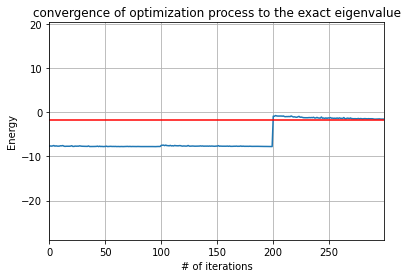

In [33]:
compare_exact_and_approximated_eigenvalue(H2_molecule_Hamiltonian_4_qubits, H2_approximated_eigenvalue)

#### Full Entangelment

In [34]:
%%time
H2_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(H2_molecule_Hamiltonian_4_qubits, "full")

15it [00:02,  7.28it/s]
15it [00:01,  7.54it/s]
15it [00:02,  7.12it/s]
15it [00:01,  7.89it/s]
15it [00:02,  7.39it/s]
15it [00:02,  7.47it/s]
15it [00:02,  7.36it/s]
15it [00:01,  7.50it/s]
15it [00:02,  7.13it/s]
15it [00:02,  6.63it/s]
15it [00:02,  6.09it/s]
15it [00:02,  7.16it/s]
15it [00:02,  7.18it/s]
15it [00:02,  7.46it/s]
15it [00:02,  7.20it/s]
15it [00:02,  6.59it/s]
15it [00:02,  6.93it/s]
15it [00:02,  6.97it/s]
15it [00:02,  6.65it/s]
15it [00:02,  6.14it/s]
15it [00:02,  6.42it/s]
15it [00:02,  7.21it/s]
15it [00:02,  7.02it/s]
15it [00:02,  6.97it/s]
15it [00:01,  7.75it/s]
15it [00:01,  8.07it/s]
15it [00:01,  8.17it/s]
15it [00:01,  7.69it/s]
15it [00:01,  7.62it/s]
15it [00:02,  7.49it/s]
15it [00:02,  7.26it/s]
15it [00:02,  6.96it/s]
15it [00:01,  7.65it/s]
15it [00:01,  7.55it/s]
15it [00:01,  7.54it/s]
15it [00:02,  6.93it/s]
15it [00:02,  6.71it/s]
15it [00:02,  7.47it/s]
15it [00:02,  7.17it/s]
15it [00:02,  7.47it/s]
15it [00:02,  6.51it/s]
15it [00:02,  6.

[ 6.31616755  3.18634846  1.59487581  4.02066994  4.35753906  1.87196223
  4.32055155  2.41073241  5.11051984 -0.07563591  4.93512272  5.00626979
  2.66367354  0.81767835  3.7425126   4.49240074  3.59917673  3.05728703
  0.49917125  4.6903242   0.45460288  1.33198101  3.38566104  0.57145371
  5.05284652  2.4693344   5.29553483  4.06680309  0.83159846  3.213306
  1.48553121  5.22994696]


15it [00:02,  7.42it/s]

CPU times: total: 3min 6s
Wall time: 3min 32s


[(-1.8572750302023793+0j), (-1.25633907300325+0j), (-1.2563390730032498+0j), (-1.2445845498133272+0j), (-1.2445845498133272+0j), (-1.244584549813327+0j), (-1.1606317377577642+0j), (-1.1606317377577642+0j), (-0.8827221502448648+0j), (-0.47189600728114256+0j), (-0.47189600728114245+0j), (-0.353325104107155+0j), (-0.353325104107155+0j), (-0.2249112528308709+0j), (-1.942890293094024e-16+0j), (0.2142782384194731+0j)]
Exact Eigenvalue:
(-1.8572750302023793+0j)

Approximated Eigenvalue:
-1.604360105509457

Approximation Error
0.13617526784138334


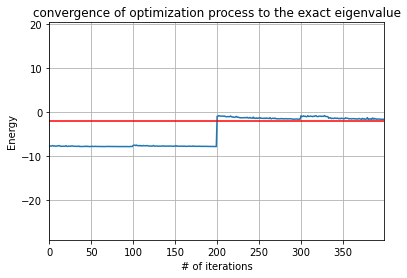

In [35]:
compare_exact_and_approximated_eigenvalue(H2_molecule_Hamiltonian_4_qubits, H2_approximated_eigenvalue)

##  Transverse Ising Model 4 qubits

In [36]:
transverse_ising_4_qubits = 0.0 * (I^I^I^I) \
    + 0.8398088405253477 * (X^I^I^I) \
    + 0.7989496312070936 * (I^X^I^I) \
    + 0.38189710487113193 * (Z^Z^I^I) \
    + 0.057753122422666725 * (I^I^X^I) \
    + 0.5633292636970458 * (Z^I^Z^I) \
    + 0.3152740621483513 * (I^Z^Z^I) \
    + 0.07209487981989715 * (I^I^I^X) \
    + 0.17892334004292654 * (Z^I^I^Z) \
    + 0.2273896497668042 * (I^Z^I^Z) \
    + 0.09762902934216211 * (I^I^Z^Z)

#### Linear Entangelment

In [37]:
%%time
TI_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(transverse_ising_4_qubits, "linear")

11it [00:01,  7.24it/s]
11it [00:01,  7.48it/s]
11it [00:01,  7.56it/s]
11it [00:01,  7.91it/s]
11it [00:01,  7.98it/s]
11it [00:01,  7.48it/s]
11it [00:01,  7.86it/s]
11it [00:01,  7.39it/s]
11it [00:01,  7.88it/s]
11it [00:01,  7.43it/s]
11it [00:01,  8.35it/s]
11it [00:01,  7.37it/s]
11it [00:01,  7.27it/s]
11it [00:01,  7.65it/s]
11it [00:01,  7.94it/s]
11it [00:01,  8.02it/s]
11it [00:01,  8.12it/s]
11it [00:01,  7.95it/s]
11it [00:01,  7.56it/s]
11it [00:01,  7.35it/s]
11it [00:01,  7.54it/s]
11it [00:01,  7.83it/s]
11it [00:01,  7.77it/s]
11it [00:01,  7.73it/s]
11it [00:01,  7.55it/s]
11it [00:01,  7.74it/s]
11it [00:01,  6.84it/s]
11it [00:01,  7.62it/s]
11it [00:01,  7.77it/s]
11it [00:01,  7.26it/s]
11it [00:01,  7.65it/s]
11it [00:01,  7.72it/s]
11it [00:01,  7.32it/s]
11it [00:01,  7.36it/s]
11it [00:01,  7.48it/s]
11it [00:01,  6.81it/s]
11it [00:01,  7.69it/s]
11it [00:01,  7.78it/s]
11it [00:01,  5.62it/s]
11it [00:02,  5.20it/s]
11it [00:01,  5.59it/s]
11it [00:02,  5.

[ 5.71173799  5.15880905  4.37812662  4.030812    3.36497404  0.12158489
  2.54579099  4.13597646  4.13770955  4.23286392  5.85330451  1.89930686
  4.47833658  2.22078302  0.78326551  2.14201522  2.84374049  0.22135936
  4.6557159   4.569917    1.81131247  0.17150421  0.63497217  4.78403146
  1.07057854 -0.32884863  4.04523133  4.00183126  4.48321246  4.35222719
  2.41956254  1.8555618 ]


11it [00:01,  7.07it/s]

CPU times: total: 2min 16s
Wall time: 2min 33s


[(-1.9994855800333675+0j), (-1.9080638482930956+0j), (-1.8497137109270194+0j), (-1.7583827504312988+0j), (-0.5462047134056278+0j), (-0.47710503946487287+0j), (-0.31907768442618767+0j), (-0.2505930484227001+0j), (0.14239915569453057+0j), (0.20992649961322052+0j), (0.2757654176709828+0j), (0.3444947223438019+0j), (1.6816520928402046+0j), (1.6958488386667439+0j), (2.3718326043433704+0j), (2.3867070442313216+0j)]
Exact Eigenvalue:
(-1.9994855800333675+0j)

Approximated Eigenvalue:
-1.515813512977261

Approximation Error
0.24189825217345903


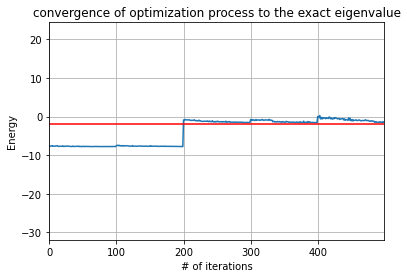

In [38]:
compare_exact_and_approximated_eigenvalue(transverse_ising_4_qubits, TI_approximated_eigenvalue)

#### Full Entangelment

In [39]:
%%time
TI_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(transverse_ising_4_qubits, "full")

11it [00:01,  7.09it/s]
11it [00:01,  7.02it/s]
11it [00:01,  6.66it/s]
11it [00:01,  6.55it/s]
11it [00:01,  6.60it/s]
11it [00:01,  6.67it/s]
11it [00:01,  6.64it/s]
11it [00:01,  6.32it/s]
11it [00:01,  6.46it/s]
11it [00:01,  6.50it/s]
11it [00:01,  6.59it/s]
11it [00:01,  6.51it/s]
11it [00:01,  7.31it/s]
11it [00:01,  6.70it/s]
11it [00:01,  6.59it/s]
11it [00:01,  6.60it/s]
11it [00:01,  6.94it/s]
11it [00:01,  6.96it/s]
11it [00:01,  6.58it/s]
11it [00:01,  6.68it/s]
11it [00:01,  6.26it/s]
11it [00:01,  6.05it/s]
11it [00:01,  6.36it/s]
11it [00:01,  6.54it/s]
11it [00:01,  6.48it/s]
11it [00:01,  6.26it/s]
11it [00:01,  6.32it/s]
11it [00:01,  6.37it/s]
11it [00:01,  6.41it/s]
11it [00:01,  6.59it/s]
11it [00:01,  6.22it/s]
11it [00:01,  5.81it/s]
11it [00:01,  6.32it/s]
11it [00:01,  6.93it/s]
11it [00:01,  6.21it/s]
11it [00:01,  6.53it/s]
11it [00:01,  6.78it/s]
11it [00:01,  6.82it/s]
11it [00:01,  6.82it/s]
11it [00:01,  6.72it/s]
11it [00:01,  6.59it/s]
11it [00:01,  6.

[3.17730336 6.4113433  2.72523452 3.53785853 3.99665169 3.91431516
 4.24088216 3.32933207 6.07577481 0.37013287 3.27714571 5.69410334
 7.45557364 2.69192136 1.98207806 2.50207847 6.21298491 2.94295204
 2.58363111 5.7062887  1.8705975  4.37763813 3.33183284 5.76337764
 4.6782095  0.30088742 0.13216785 3.64949734 3.44767755 1.61473685
 0.39252356 3.9500812 ]


11it [00:01,  7.89it/s]

CPU times: total: 2min 18s
Wall time: 2min 43s


[(-1.9994855800333675+0j), (-1.9080638482930956+0j), (-1.8497137109270194+0j), (-1.7583827504312988+0j), (-0.5462047134056278+0j), (-0.47710503946487287+0j), (-0.31907768442618767+0j), (-0.2505930484227001+0j), (0.14239915569453057+0j), (0.20992649961322052+0j), (0.2757654176709828+0j), (0.3444947223438019+0j), (1.6816520928402046+0j), (1.6958488386667439+0j), (2.3718326043433704+0j), (2.3867070442313216+0j)]
Exact Eigenvalue:
(-1.9994855800333675+0j)

Approximated Eigenvalue:
-1.8528064702140934

Approximation Error
0.07335842342850321


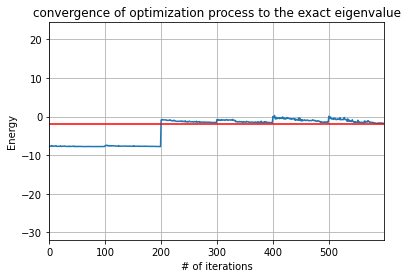

In [40]:
compare_exact_and_approximated_eigenvalue(transverse_ising_4_qubits, TI_approximated_eigenvalue)

##  Transverse Ising Model 3 qubits

In [41]:
QUBITS_NUM = 3 
N = 2**QUBITS_NUM

NUM_SHOTS = 1024
NUM_ITERATIONS = 100

CIRCUIT_DEPTH = 3
PARAMS_NUM = 2*QUBITS_NUM*(CIRCUIT_DEPTH+1)

In [42]:
from qiskit.opflow import X, Z, I

transverse_ising_3_qubits = 0.0 * (I^I^I) \
                    + 0.012764169333459807 * (X^I^I) \
                    + 0.7691573729160869 * (I^X^I) \
                    + 0.398094746026449 * (Z^Z^I) \
                    + 0.15250261906586637 * (I^I^X) \
                    + 0.2094051920882264 * (Z^I^Z) \
                    + 0.5131291860752999 * (I^Z^Z)

#### Linear Entangelment

In [43]:
%%time
TI_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(transverse_ising_3_qubits, "linear")

7it [00:00,  8.27it/s]
7it [00:00,  8.79it/s]
7it [00:00,  9.23it/s]
7it [00:00,  9.32it/s]
7it [00:00,  9.61it/s]
7it [00:00, 10.22it/s]
7it [00:00,  8.99it/s]
7it [00:00,  9.82it/s]
7it [00:00,  9.45it/s]
7it [00:00,  9.01it/s]
7it [00:00,  8.72it/s]
7it [00:00,  9.27it/s]
7it [00:00,  9.51it/s]
7it [00:00,  9.50it/s]
7it [00:00,  9.85it/s]
7it [00:00,  9.50it/s]
7it [00:00,  9.23it/s]
7it [00:00,  9.73it/s]
7it [00:00, 10.02it/s]
7it [00:00, 10.68it/s]
7it [00:00,  9.84it/s]
7it [00:00,  9.63it/s]
7it [00:00,  7.79it/s]
7it [00:00,  8.69it/s]
7it [00:00,  9.17it/s]
7it [00:00,  9.04it/s]
7it [00:00,  9.27it/s]
7it [00:00,  9.53it/s]
7it [00:00,  8.87it/s]
7it [00:00,  9.51it/s]
7it [00:00,  8.58it/s]
7it [00:00,  9.84it/s]
7it [00:00,  9.30it/s]
7it [00:00,  8.83it/s]
7it [00:00,  9.78it/s]
7it [00:00, 10.52it/s]
7it [00:00,  9.73it/s]
7it [00:00, 10.46it/s]
7it [00:00,  9.58it/s]
7it [00:00, 10.13it/s]
7it [00:00,  9.44it/s]
7it [00:00,  8.88it/s]
7it [00:01,  6.73it/s]
7it [00:00,

[ 4.47979061  0.23770846  5.07245287  0.71879312  0.41685288  5.31149249
  1.6381399   2.14710919  5.91769439  2.96713118  4.85957471 -0.01108683
  1.25440464  3.91472229  6.12922677  6.34264457  4.18408047  1.89521302
  5.76713272  0.9691314   5.35836149  1.22155863  4.17098656  5.65478029]


7it [00:00,  9.52it/s]

CPU times: total: 1min 5s
Wall time: 1min 13s


[(-1.1327102067329746+0j), (-1.1089522226243493+0j), (-0.8673630797839832+0j), (-0.8433012058342556+0j), (0.5479228225821259+0j), (0.5543478038595204+0j), (1.4216636087077101+0j), (1.4283924798262082+0j)]
Exact Eigenvalue:
(-1.1327102067329746+0j)

Approximated Eigenvalue:
-0.923768900731251

Approximation Error
0.18446139600380554


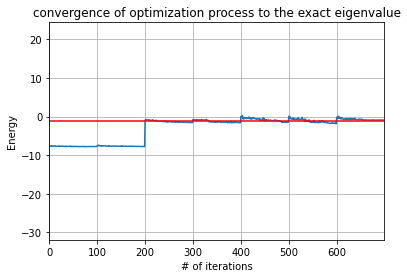

In [44]:
compare_exact_and_approximated_eigenvalue(transverse_ising_3_qubits, TI_approximated_eigenvalue)

#### Full Entangelment

In [45]:
%%time
TI_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(transverse_ising_3_qubits, "full")

7it [00:00,  9.19it/s]
7it [00:00, 10.08it/s]
7it [00:00,  9.14it/s]
7it [00:00,  9.60it/s]
7it [00:00,  9.55it/s]
7it [00:00,  9.08it/s]
7it [00:00,  9.44it/s]
7it [00:00,  9.21it/s]
7it [00:00,  9.85it/s]
7it [00:00,  9.88it/s]
7it [00:00, 10.02it/s]
7it [00:00, 10.92it/s]
7it [00:00,  9.22it/s]
7it [00:00, 10.34it/s]
7it [00:00,  9.40it/s]
7it [00:00,  9.29it/s]
7it [00:00,  8.87it/s]
7it [00:00,  8.30it/s]
7it [00:00,  9.19it/s]
7it [00:00,  8.89it/s]
7it [00:00,  9.09it/s]
7it [00:00,  7.62it/s]
7it [00:00,  9.13it/s]
7it [00:00,  9.69it/s]
7it [00:00,  8.43it/s]
7it [00:00,  9.29it/s]
7it [00:00,  9.90it/s]
7it [00:00,  9.11it/s]
7it [00:00,  8.14it/s]
7it [00:00,  9.17it/s]
7it [00:00,  9.19it/s]
7it [00:00,  9.00it/s]
7it [00:00,  9.30it/s]
7it [00:00,  9.15it/s]
7it [00:00,  8.36it/s]
7it [00:00,  8.69it/s]
7it [00:00,  8.12it/s]
7it [00:00,  8.09it/s]
7it [00:00,  7.65it/s]
7it [00:00,  8.21it/s]
7it [00:00,  8.19it/s]
7it [00:00,  9.04it/s]
7it [00:00,  8.78it/s]
7it [00:00,

[-0.16110888  3.22203462  4.41664747  6.56469284  4.91706983  1.36688518
  1.75118431  3.61517507  5.3985202   1.67471751  2.58470092  3.47324144
  3.99750253  5.26641504  2.84274623  2.9979098   3.4152806   5.75453106
  0.02435335  0.97794453  2.18014579  4.75377019  0.93743903  5.50199084]


7it [00:00,  9.68it/s]

CPU times: total: 1min 8s
Wall time: 1min 20s


[(-1.1327102067329746+0j), (-1.1089522226243493+0j), (-0.8673630797839832+0j), (-0.8433012058342556+0j), (0.5479228225821259+0j), (0.5543478038595204+0j), (1.4216636087077101+0j), (1.4283924798262082+0j)]
Exact Eigenvalue:
(-1.1327102067329746+0j)

Approximated Eigenvalue:
-0.8354079459608915

Approximation Error
0.26246983474226715


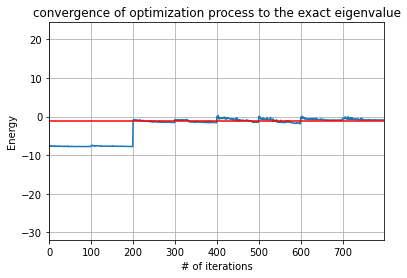

In [46]:
compare_exact_and_approximated_eigenvalue(transverse_ising_3_qubits, TI_approximated_eigenvalue)

##  Transverse Ising Model 2 qubits

In [47]:
QUBITS_NUM = 2 
N = 2**QUBITS_NUM

NUM_SHOTS = 1024
NUM_ITERATIONS = 100

CIRCUIT_DEPTH = 3
PARAMS_NUM = 2*QUBITS_NUM*(CIRCUIT_DEPTH+1)

In [48]:
transverse_ising_2_qubits = 0.13755727363376802 * (I^X) \
                            + 0.43305656297810435 * (X^I) \
                            + 0.8538597608997253 * (Z^Z)

#### Linear Entangelment

In [49]:
%%time
TI_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(transverse_ising_2_qubits, "linear")

3it [00:00, 10.72it/s]
3it [00:00, 11.95it/s]
3it [00:00, 14.98it/s]
3it [00:00, 11.07it/s]
3it [00:00, 14.35it/s]
3it [00:00, 12.83it/s]
3it [00:00, 11.24it/s]
3it [00:00, 16.53it/s]
3it [00:00, 12.39it/s]
3it [00:00, 11.26it/s]
3it [00:00, 13.81it/s]
3it [00:00, 12.24it/s]
3it [00:00, 12.16it/s]
3it [00:00, 14.20it/s]
3it [00:00, 14.59it/s]
3it [00:00, 12.07it/s]
3it [00:00, 15.53it/s]
3it [00:00, 12.36it/s]
3it [00:00, 17.02it/s]
3it [00:00, 13.73it/s]
3it [00:00, 10.85it/s]
3it [00:00, 14.66it/s]
3it [00:00, 14.64it/s]
3it [00:00, 10.99it/s]
3it [00:00, 13.88it/s]
3it [00:00, 13.98it/s]
3it [00:00, 12.54it/s]
3it [00:00, 15.98it/s]
3it [00:00, 11.13it/s]
3it [00:00, 12.91it/s]
3it [00:00, 12.75it/s]
3it [00:00, 13.64it/s]
3it [00:00, 11.03it/s]
3it [00:00, 13.39it/s]
3it [00:00, 11.18it/s]
3it [00:00, 15.02it/s]
3it [00:00, 15.47it/s]
3it [00:00, 11.69it/s]
3it [00:00, 15.95it/s]
3it [00:00, 12.52it/s]
3it [00:00, 11.37it/s]
3it [00:00, 13.72it/s]
3it [00:00, 11.94it/s]
3it [00:00,

[ 3.57686821  3.58476361  2.3107557   4.04828355  6.50874402  1.55060267
  1.14974589 -0.10702539  5.51459524  6.24092198  3.10221254  5.76735642
  2.4419546   1.02114178  2.64892515  5.10436133]


3it [00:00, 13.81it/s]

CPU times: total: 22.1 s
Wall time: 24.6 s


[(-1.0269745088446245+0j), (-0.9035465241407018+0j), (0.9035465241407012+0j), (1.0269745088446243+0j)]
Exact Eigenvalue:
(-1.0269745088446245+0j)

Approximated Eigenvalue:
-1.145319020897557

Approximation Error
0.11523607551474033


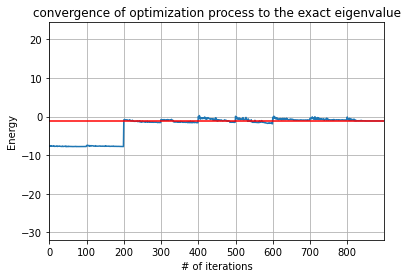

In [50]:
compare_exact_and_approximated_eigenvalue(transverse_ising_2_qubits, TI_approximated_eigenvalue)

#### Full Entangelment

In [51]:
%%time
TI_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(transverse_ising_2_qubits, "full")

3it [00:00, 13.22it/s]
3it [00:00, 10.20it/s]
3it [00:00, 12.88it/s]
3it [00:00, 14.88it/s]
3it [00:00, 14.27it/s]
3it [00:00, 10.38it/s]
3it [00:00, 15.20it/s]
3it [00:00, 15.80it/s]
3it [00:00, 11.16it/s]
3it [00:00, 13.45it/s]
3it [00:00, 13.17it/s]
3it [00:00, 11.02it/s]
3it [00:00, 13.15it/s]
3it [00:00, 12.75it/s]
3it [00:00, 10.60it/s]
3it [00:00, 15.27it/s]
3it [00:00, 12.26it/s]
3it [00:00, 12.71it/s]
3it [00:00, 13.83it/s]
3it [00:00, 14.18it/s]
3it [00:00, 11.72it/s]
3it [00:00, 13.15it/s]
3it [00:00, 13.58it/s]
3it [00:00, 10.09it/s]
3it [00:00, 13.96it/s]
3it [00:00, 14.90it/s]
3it [00:00, 10.71it/s]
3it [00:00, 14.25it/s]
3it [00:00, 14.53it/s]
3it [00:00, 12.37it/s]
3it [00:00, 13.66it/s]
3it [00:00, 14.75it/s]
3it [00:00, 11.07it/s]
3it [00:00, 14.30it/s]
3it [00:00, 13.25it/s]
3it [00:00, 12.32it/s]
3it [00:00, 14.85it/s]
3it [00:00, 13.66it/s]
3it [00:00, 11.47it/s]
3it [00:00, 13.47it/s]
3it [00:00, 15.52it/s]
3it [00:00, 11.62it/s]
3it [00:00, 11.99it/s]
3it [00:00,

[ 2.83685112  4.20892347  1.2127437   1.28693477  3.92003719  3.29763872
  3.30537262  4.30583439  4.52130097  4.39663422 -0.21608839  0.93525796
  2.17865071  0.34528419  2.99386465  0.2262219 ]


3it [00:00, 13.66it/s]

CPU times: total: 21.8 s
Wall time: 24.5 s


[(-1.0269745088446245+0j), (-0.9035465241407018+0j), (0.9035465241407012+0j), (1.0269745088446243+0j)]
Exact Eigenvalue:
(-1.0269745088446245+0j)

Approximated Eigenvalue:
-1.0809723403699616

Approximation Error
0.0525795246720254


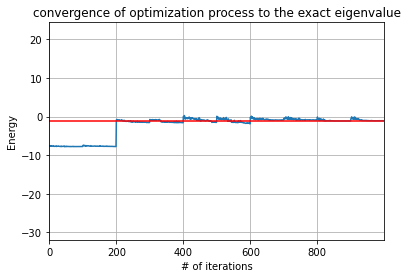

In [52]:
compare_exact_and_approximated_eigenvalue(transverse_ising_2_qubits, TI_approximated_eigenvalue)

## H2 Molecule 2 qubits

In [53]:
from qiskit.opflow import X, Z, I

H2_molecule_Hamiltonian_2_qubits = -0.5053051899926562*(I^I) + \
                            -0.3277380754984016*(Z^I) + \
                            0.15567463610622564*(Z^Z) + \
                            -0.3277380754984016*(I^Z)

#### Linear Entangelment

In [54]:
%%time
H2_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(H2_molecule_Hamiltonian_2_qubits, "linear")

4it [00:00, 12.35it/s]
4it [00:00, 13.96it/s]
4it [00:00,  9.66it/s]
4it [00:00, 14.33it/s]
4it [00:00, 11.81it/s]
4it [00:00, 12.93it/s]
4it [00:00, 11.44it/s]
4it [00:00, 14.43it/s]
4it [00:00, 16.08it/s]
4it [00:00, 12.98it/s]
4it [00:00, 14.59it/s]
4it [00:00, 13.75it/s]
4it [00:00, 12.91it/s]
4it [00:00, 14.25it/s]
4it [00:00, 11.49it/s]
4it [00:00, 15.84it/s]
4it [00:00, 10.73it/s]
4it [00:00, 14.03it/s]
4it [00:00, 14.47it/s]
4it [00:00, 14.27it/s]
4it [00:00, 11.80it/s]
4it [00:00, 15.43it/s]
4it [00:00, 12.36it/s]
4it [00:00, 13.93it/s]
4it [00:00, 15.00it/s]
4it [00:00, 13.54it/s]
4it [00:00, 13.49it/s]
4it [00:00, 10.34it/s]
4it [00:00, 14.55it/s]
4it [00:00, 15.09it/s]
4it [00:00, 11.91it/s]
4it [00:00, 14.60it/s]
4it [00:00, 10.85it/s]
4it [00:00, 13.25it/s]
4it [00:00, 12.42it/s]
4it [00:00, 14.00it/s]
4it [00:00, 12.45it/s]
4it [00:00, 12.66it/s]
4it [00:00, 12.33it/s]
4it [00:00, 12.28it/s]
4it [00:00, 11.16it/s]
4it [00:00, 13.20it/s]
4it [00:00, 14.27it/s]
4it [00:00,

[4.10034933 6.65996832 4.46432956 0.45900631 3.9749553  5.6809294
 1.70617417 0.21660472 0.79612904 3.34309152 0.94704372 1.03910995
 5.71368116 0.92371338 3.17771698 1.26462812]


4it [00:00, 15.91it/s]

CPU times: total: 28.4 s
Wall time: 32 s


[(-1.0051067048832336+0j), (-0.6609798260988818+0j), (-0.6609798260988818+0j), (0.30584559711037274+0j)]
Exact Eigenvalue:
(-1.0051067048832336+0j)

Approximated Eigenvalue:
-1.0001298025701268

Approximation Error
0.004951615872152549


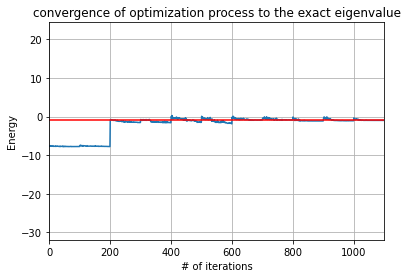

In [55]:
compare_exact_and_approximated_eigenvalue(H2_molecule_Hamiltonian_2_qubits, H2_approximated_eigenvalue)

#### Full Entangelment

In [56]:
%%time
H2_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(H2_molecule_Hamiltonian_2_qubits, "full")

4it [00:00, 14.69it/s]
4it [00:00, 12.60it/s]
4it [00:00, 13.68it/s]
4it [00:00, 12.99it/s]
4it [00:00, 13.24it/s]
4it [00:00, 13.23it/s]
4it [00:00, 13.64it/s]
4it [00:00, 13.50it/s]
4it [00:00, 13.12it/s]
4it [00:00, 15.27it/s]
4it [00:00, 14.43it/s]
4it [00:00, 13.72it/s]
4it [00:00, 15.08it/s]
4it [00:00, 12.31it/s]
4it [00:00,  9.73it/s]
4it [00:00, 13.77it/s]
4it [00:00, 14.35it/s]
4it [00:00, 13.99it/s]
4it [00:00, 15.02it/s]
4it [00:00, 14.31it/s]
4it [00:00, 11.86it/s]
4it [00:00, 13.74it/s]
4it [00:00, 13.07it/s]
4it [00:00, 15.48it/s]
4it [00:00, 12.56it/s]
4it [00:00, 14.51it/s]
4it [00:00, 11.42it/s]
4it [00:00, 13.62it/s]
4it [00:00, 11.77it/s]
4it [00:00, 14.27it/s]
4it [00:00, 14.05it/s]
4it [00:00, 13.65it/s]
4it [00:00, 15.66it/s]
4it [00:00, 14.27it/s]
4it [00:00, 14.17it/s]
4it [00:00, 13.73it/s]
4it [00:00, 16.08it/s]
4it [00:00, 14.76it/s]
4it [00:00, 12.48it/s]
4it [00:00, 15.43it/s]
4it [00:00, 13.18it/s]
4it [00:00, 13.39it/s]
4it [00:00, 14.69it/s]
4it [00:00,

[7.00683242 1.63502446 5.50571157 2.44627541 1.82263586 3.13767041
 3.94752122 0.96392378 4.49006165 0.53113032 5.70745587 2.66237751
 5.1644921  0.2415953  0.40619608 6.72408971]


4it [00:00, 15.20it/s]

CPU times: total: 28.6 s
Wall time: 30.6 s


[(-1.0051067048832336+0j), (-0.6609798260988818+0j), (-0.6609798260988818+0j), (0.30584559711037274+0j)]
Exact Eigenvalue:
(-1.0051067048832336+0j)

Approximated Eigenvalue:
-1.002466190615033

Approximation Error
0.0026270984517085907


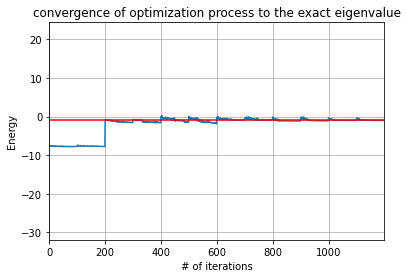

In [57]:
compare_exact_and_approximated_eigenvalue(H2_molecule_Hamiltonian_2_qubits, H2_approximated_eigenvalue)